### Import the Packages and Read in the Files  

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [114]:
df=pd.read_csv("Ontario daily cases.csv",thousands=",")
df.shape
df = df.replace(',','', regex=True)

### Data Preprocessing 

In [115]:
## Get the last 196 records
df=df.iloc[-196:,:2]
df.shape

(196, 2)

In [116]:
df.head()

,Date,Cases by episode date
20,2020-02-04,0
21,2020-02-05,1
22,2020-02-06,0
23,2020-02-07,0
24,2020-02-08,0


In [117]:
## set the date to the datetime form and set them as index
df.Date = pd.to_datetime(df.Date)
df =df.set_index("Date")
## Check
df.head()

,Cases by episode date
Date,
2020-02-04,0
2020-02-05,1
2020-02-06,0
2020-02-07,0
2020-02-08,0


In [118]:
## split the train and test data
train, test = df[:-30],df[-30:]
## Set the scaler
scaler=MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

In [119]:
## Change the data in the form of time series
n_input = 14
n_features=1

generator =TimeseriesGenerator(train,train,length=n_input,batch_size=6)

### Train and  Evaluate the Model

In [120]:
## build LSTM
model = Sequential()
model.add(LSTM(150,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(150,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

## Fit the model to the training set
history =model.fit_generator(generator,epochs=180)

Epoch 1/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0857
Epoch 2/180
26/26 [==============================] - 0s 12ms/step - loss: 0.0317
Epoch 3/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0434
Epoch 4/180
26/26 [==============================] - 0s 12ms/step - loss: 0.0294
Epoch 5/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0328
Epoch 6/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0322
Epoch 7/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0256
Epoch 8/180
26/26 [==============================] - 0s 12ms/step - loss: 0.0344
Epoch 9/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0211
Epoch 10/180
26/26 [==============================] - 0s 10ms/step - loss: 0.0292
Epoch 11/180
26/26 [==============================] - 0s 11ms/step - loss: 0.0235
Epoch 12/180
26/26 [==============================] - 0s 10ms/step - loss: 0.0186
Epoch 13/180
26/26 [=====

In [121]:
## Calculate the fitted value on the testing data set
fit_list = []
batch_fit = train[:n_input].reshape(1, n_input,n_features)

train_list = train.tolist()

train_list[1]
for i in range(152):
    fit_list.append(model.predict(batch_fit)[0])
    batch_fit = np.append(batch_fit[:,1:,:], [[train_list[n_input+i]]],axis=1)

In [122]:
## Calculate 30 predictions on the validation set
pred_list =[]
batch =train[-n_input:].reshape(1,n_input,n_features)

for i in range(30):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)

In [123]:
## inverse the scaler (change to the real values), and the make the value to a dataframe
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),index=df[-30:].index,columns=["Prediction_Canada"])
df_fitted = pd.DataFrame(scaler.inverse_transform(fit_list),index=df[14:-30].index,columns=["Fitted_Canada"])
## concatnate the predicted values with the real values
df_test = pd.concat([df,df_predict,df_fitted], axis=1)

In [124]:
## rmse
df_mse=df_test[-30:]
rmse= ((df_mse["Cases by episode date"] - df_mse["Prediction_Canada"]) ** 2).mean() ** .5
print("Total loss on prediction for validation data is",rmse)

Total loss on prediction for validation data is 63.128133261110456


### Plot 

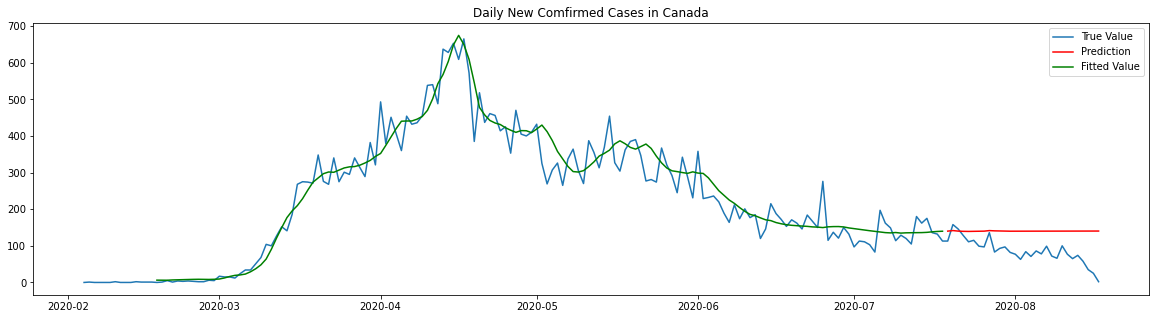

In [125]:
## plot the true value of daily cases, fitted value on the testing data, and the prediction on the validation data
plt.figure(figsize=(20,5))
plt.plot(df_test.index,df_test["Cases by episode date"],label="True Value")
plt.plot(df_test.index,df_test["Prediction_Canada"],color="r",label="Prediction")
plt.plot(df_test.index,df_test["Fitted_Canada"],color="g",label="Fitted Value")
plt.title("Daily New Comfirmed Cases in Canada")
plt.legend(loc="upper right")
plt.show()

In [126]:
df_test.tail(30)

,Cases by episode date,Prediction_Canada,Fitted_Canada
Date,,,
2020-07-19,113,140.118952,NaN
2020-07-20,158,141.627847,NaN
2020-07-21,146,140.182847,NaN
2020-07-22,128,139.541380,NaN
2020-07-23,111,139.320948,NaN
2020-07-24,115,139.503497,NaN
2020-07-25,99,139.617493,NaN
2020-07-26,97,140.055652,NaN
2020-07-27,136,141.580728,NaN


### Experiments 

| Prediction Window | Layers |Hidden States|Dropout| RMSE |
| --- | --- | --- |---|---|
| 30 | 3 |150/150/50|0.15|106.50|
| 30 | 3 |150/150/50|0.20|71.25|
| 30 | 3 |150/150/50|0.25|55.99|
| 30 | 3 |150/150/50|0.30|68.74|
| 30 | 4 |150/150/150/50|0.30|65.73|
| 30 | 3 |150/100/100|0.25|52.72|

### Prediction

In [127]:
## Now the training data will be all the data in the dataframe (known data)
## We fit the model to the new training data
train = df
scaler.fit(train)
train = scaler.transform(train)

n_input=14
n_features =1
generator = TimeseriesGenerator(train,train,length=n_input,batch_size=6)

model.fit_generator(generator, epochs=180)

Epoch 1/180
31/31 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 2/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0083
Epoch 3/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 4/180
31/31 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 5/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 6/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 7/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 8/180
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 9/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0078
Epoch 10/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 11/180
31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 12/180
31/31 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 13/180
31/31 [=====

In [128]:
## Predictions on the cases for the following 14 days
pred_list =[]
batch =train[-n_input:].reshape(1,n_input,n_features)

for i in range(14):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)

In [129]:
## create a dataframe with new index
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1]+DateOffset(days=x)for x in range(0,15)]
future_dates =pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [132]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),index=future_dates[-14:].index,columns=["Prediction_Canada"])
df_predict.loc[df_predict.Prediction_Canada < 0, 'Prediction_Canada'] = 0
df_test = pd.concat([df,df_predict], axis=1)    
df_test.tail(15)

,Cases by episode date,Prediction_Canada
2020-08-17,2.0,NaN
2020-08-18,NaN,17.293196
2020-08-19,NaN,10.215984
2020-08-20,NaN,4.568908
2020-08-21,NaN,1.788564
2020-08-22,NaN,0.000000
2020-08-23,NaN,0.000000
2020-08-24,NaN,0.000000
2020-08-25,NaN,0.000000
2020-08-26,NaN,0.000000


### Plot the prediction 

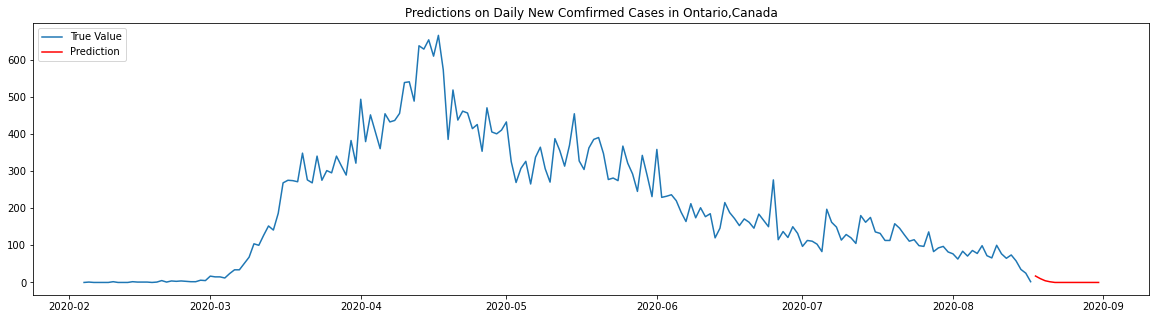

In [133]:
## visulisation
plt.figure(figsize=(20,5))
plt.plot(df_test.index,df_test["Cases by episode date"],label="True Value")
plt.plot(df_test.index,df_test["Prediction_Canada"],color="r",label="Prediction")
plt.title("Predictions on Daily New Comfirmed Cases in Ontario,Canada")
plt.legend(loc="upper left")
plt.show()